In [150]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sstdataset/SST-2/test.tsv
/kaggle/input/sstdataset/SST-2/dev.tsv
/kaggle/input/sstdataset/SST-2/train.tsv
/kaggle/input/sstdataset/SST-2/original/datasetSentences.txt
/kaggle/input/sstdataset/SST-2/original/STree.txt
/kaggle/input/sstdataset/SST-2/original/README.txt
/kaggle/input/sstdataset/SST-2/original/original_rt_snippets.txt
/kaggle/input/sstdataset/SST-2/original/SOStr.txt
/kaggle/input/sstdataset/SST-2/original/dictionary.txt
/kaggle/input/sstdataset/SST-2/original/sentiment_labels.txt
/kaggle/input/sstdataset/SST-2/original/datasetSplit.txt
/kaggle/input/multinli-nyu/multinli_1.0/README.txt
/kaggle/input/multinli-nyu/multinli_1.0/paper.pdf
/kaggle/input/multinli-nyu/multinli_1.0/multinli_1.0_dev_matched.txt
/kaggle/input/multinli-nyu/multinli_1.0/multinli_1.0_dev_mismatched.txt
/kaggle/input/multinli-nyu/multinli_1.0/multinli_1.0_train.txt
/kaggle/input/gnewsvector/GoogleNews-vectors-negative300.bin
/kaggle/input/stsbenchmark/COVID_Ethics_dev.csv
/kaggle/input/st

# Task1: Sentiment Analysis

## Importing the dataset

In [151]:
# SST-2

df_train = pd.read_csv('../input/sstdataset/SST-2/train.tsv', sep='\t').dropna()
df_test = pd.read_csv('../input/sstdataset/SST-2/test.tsv', sep='\t').dropna()
df_valid = pd.read_csv('../input/sstdataset/SST-2/dev.tsv', sep='\t').dropna()
y_train = df_train['label']
y_valid = df_valid['label']
df_train = df_train['sentence']
df_valid = df_valid['sentence']

df_train.head()

0         hide new secretions from the parental units 
1                 contains no wit , only labored gags 
2    that loves its characters and communicates som...
3    remains utterly satisfied to remain the same t...
4    on the worst revenge-of-the-nerds clichés the ...
Name: sentence, dtype: object

In [152]:
y_train.value_counts()

1    37569
0    29780
Name: label, dtype: int64

## Building deep learning model

In [153]:
from tensorflow.keras.preprocessing.text import Tokenizer
max_words=10000
tokenizer=Tokenizer(max_words)
tokenizer.fit_on_texts(df_train)
sequence_train=tokenizer.texts_to_sequences(df_train)
sequence_valid=tokenizer.texts_to_sequences(df_valid)

In [154]:
word2vec=tokenizer.word_index
V=len(word2vec)
print('dataset has %s number of independent tokens' %V)

dataset has 13822 number of independent tokens


In [155]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
data_train=pad_sequences(sequence_train)
data_train.shape

(67349, 49)

In [156]:
T=data_train.shape[1]
data_valid=pad_sequences(sequence_valid,maxlen=T)
data_valid.shape

(872, 49)

In [157]:
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Dense,GlobalMaxPooling1D,Embedding,Bidirectional,LSTM,Dropout
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras import utils

In [158]:
D=20
i=Input((T,))
x=Embedding(V+1,D)(i)
x=Conv1D(32,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(64,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(128,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dense(1,activation='sigmoid')(x)
model=Model(i,x)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 49)]              0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 49, 20)            276460    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 47, 32)            1952      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 15, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 13, 64)            6208      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 2, 128)            2470

## Training the model (CNN)

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
cnn_senti=model.fit(data_train,y_train,validation_data=(data_test,y_test),epochs=10,batch_size=100)

## Training the model (BiLSTM)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 49, 20)            276460    
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 128)               43520     
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 10)                1290      
_________________________________________________________________
dropout_27 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 11        
Total params: 321,281
Trainable params: 321,281
Non-trainable params: 0
_______________________________________________

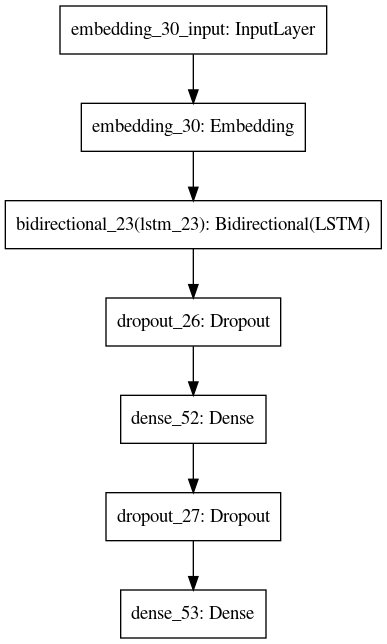

In [221]:
model = Sequential()
D=20
model.add(Embedding(V+1, D, input_length=T))
lstm_out = 64
model.add(Bidirectional(LSTM(lstm_out)))
model.add(Dropout(.1, input_shape=(128,)))
model.add(Dense(10, activation='relu'))
model.add(Dropout(.1, input_shape=(10,)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='RMSProp', metrics=['accuracy'])
model.summary()
utils.plot_model(model, show_shapes=False, expand_nested=True, to_file='sentiment.png')

In [166]:
lstm_senti = model.fit(data_train,y_train,validation_data=(data_valid,y_valid),epochs=10,batch_size=128)


Epoch 1/10
527/527 [==============================] - 6s 11ms/step - loss: 0.4550 - accuracy: 0.7776 - val_loss: 0.4535 - val_accuracy: 0.8200
Epoch 2/10
527/527 [==============================] - 6s 11ms/step - loss: 0.2768 - accuracy: 0.8879 - val_loss: 0.4900 - val_accuracy: 0.8154
Epoch 3/10
527/527 [==============================] - 5s 10ms/step - loss: 0.2486 - accuracy: 0.8994 - val_loss: 0.4916 - val_accuracy: 0.8245
Epoch 4/10
527/527 [==============================] - 5s 10ms/step - loss: 0.2356 - accuracy: 0.9047 - val_loss: 0.4901 - val_accuracy: 0.8257
Epoch 5/10
527/527 [==============================] - 5s 9ms/step - loss: 0.2228 - accuracy: 0.9106 - val_loss: 0.4304 - val_accuracy: 0.8337
Epoch 6/10
527/527 [==============================] - 5s 10ms/step - loss: 0.2117 - accuracy: 0.9150 - val_loss: 0.4621 - val_accuracy: 0.8234
Epoch 7/10
527/527 [==============================] - 5s 9ms/step - loss: 0.1997 - accuracy: 0.9191 - val_loss: 0.4694 - val_accuracy: 0.8188
E

## Evaluation

In [212]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})

def plot_training(training, filename, ymin=0.5, valid=True):
    plt.figure(figsize=(16, 5), dpi=300)
    plt.subplot(1,2,1)
    plt.plot(training.history['accuracy'], label='accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    if valid:
        plt.plot(training.history['val_accuracy'], color='red', linestyle='dashed')
        plt.legend(['train', 'validation'])
    plt.ylim([ymin, 1])

    plt.subplot(1,2,2)
    plt.plot(training.history['loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    if valid:
        plt.plot(training.history['val_loss'], color='red', linestyle='dashed')
        plt.legend(['train', 'validation'])
    plt.savefig(filename, bbox='tight')
    plt.show()

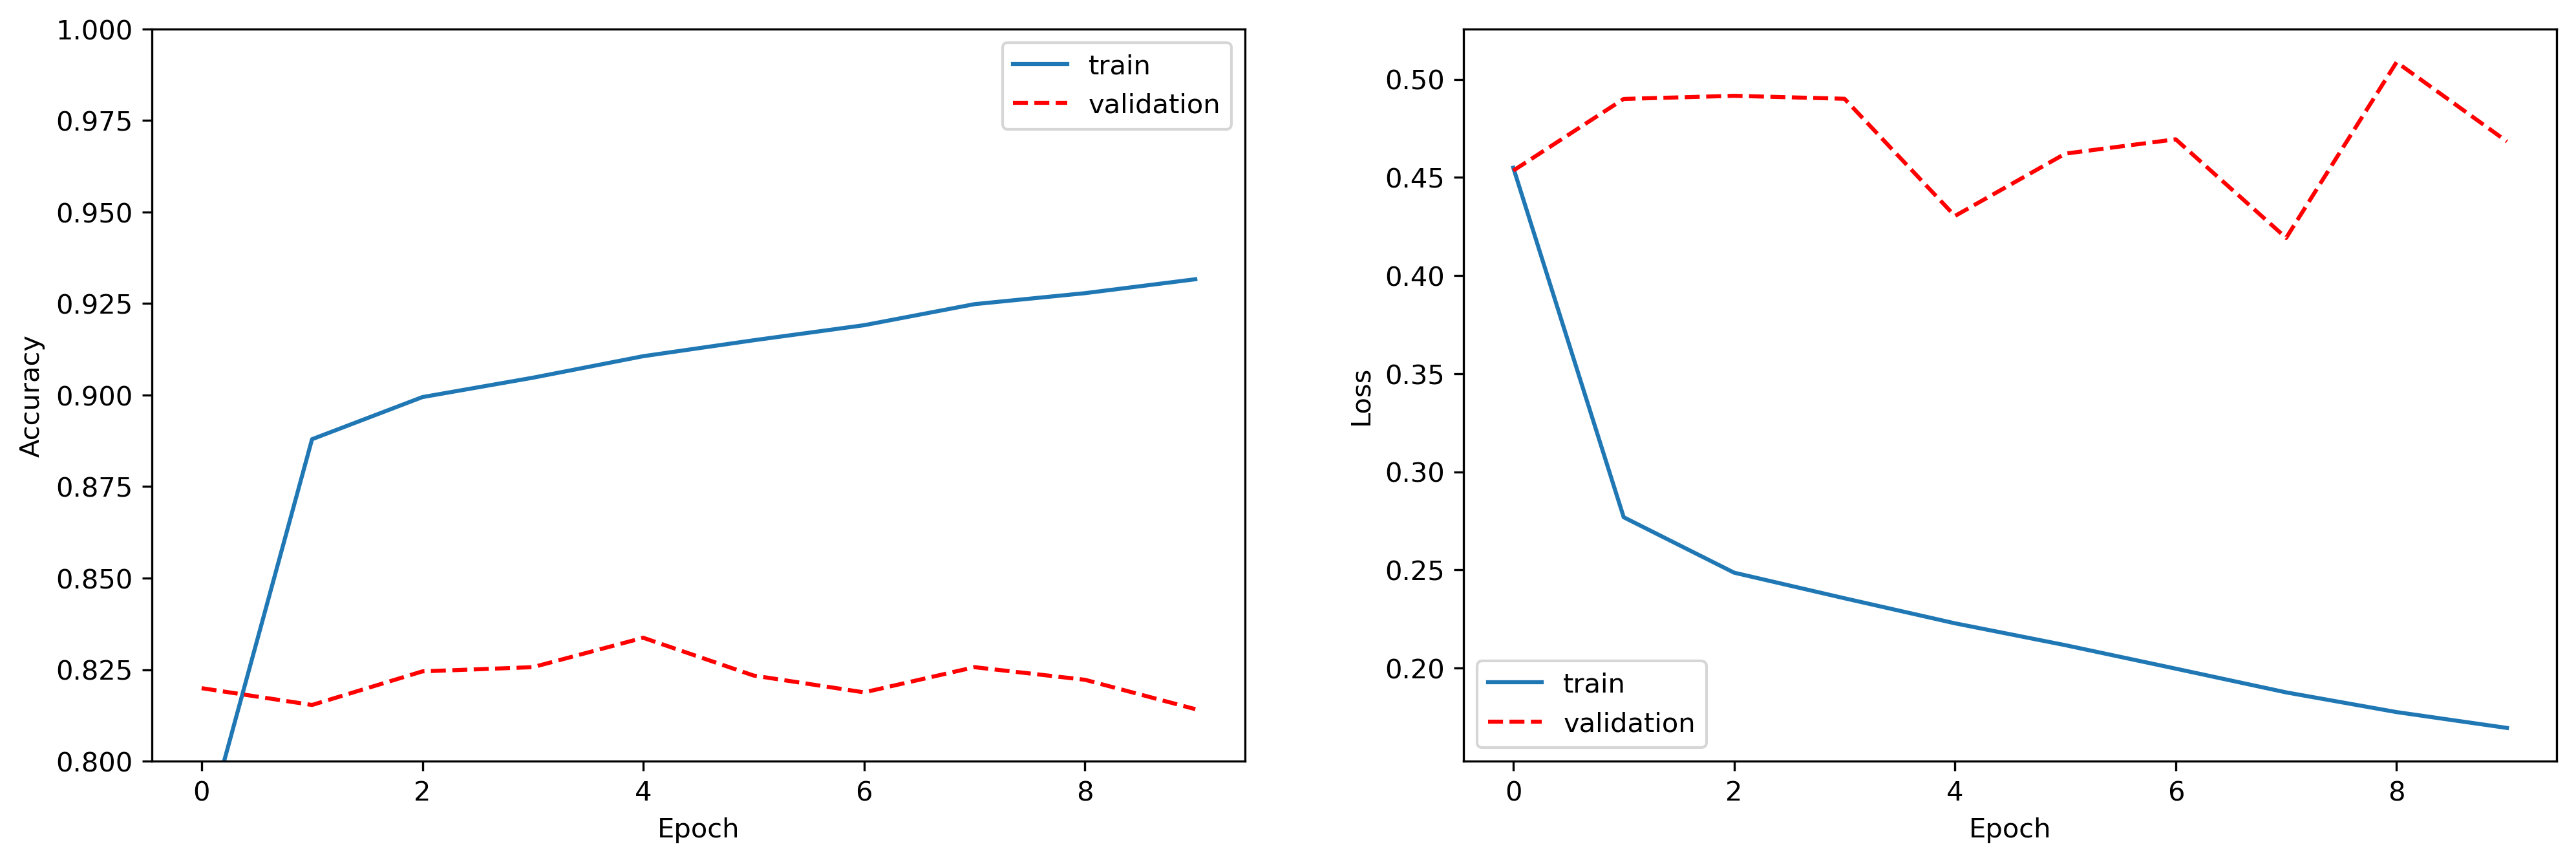

In [167]:
plot_training(lstm_senti, 'sst2.pdf', ymin=0.8)

# Task2: Semantic Textual Similarity

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
sts_train = pd.DataFrame(load_dataset('glue', 'stsb', split='train')).fillna('')
sts_eval = pd.DataFrame(load_dataset('glue', 'stsb', split='validation')).fillna('')
sts_test = pd.DataFrame(load_dataset('glue', 'stsb', split='test')).fillna('')

In [ ]:
import nltk
from nltk.corpus import stopwords

def remove_stopwords(dataset):
    data = dataset.copy()
    data[['sentence1', 'sentence2']] = dataset[['sentence1', 'sentence2']].apply(lambda x: x.astype(str).str.lower())  
    data['sentence1'] = data.apply(lambda row: nltk.word_tokenize(row['sentence1']), axis=1).apply(lambda x: [item for item in x if item not in stopwords.words('english')])
    data['sentence2'] = data.apply(lambda row: nltk.word_tokenize(row['sentence2']), axis=1).apply(lambda x: [item for item in x if item not in stopwords.words('english')])
    return data

In [ ]:
sts_train_stop = remove_stopwords(sts_train)
sts_test_stop = remove_stopwords(sts_test)

In [ ]:
def get_document_frequency(df):
    document_frequency_dict = {}
    all_sentences =  df[["sentence1", "sentence2"]]
    sentences = all_sentences.values.flatten().tolist()
    n = len(sentences)

    for s in sentences:
        for token in set(s):
            document_frequency_dict[token] = document_frequency_dict.get(token, 0) + 1

    return document_frequency_dict, n

document_frequencies, num_documents = get_document_frequency(sts_train_stop)
num_documents

In [ ]:
from gensim import models
word2vec_path = '../input/gnewsvector/GoogleNews-vectors-negative300.bin'
word2vec_model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
def average_sentence_embedding(tokens, embedding_model):
    tokens = [i for i in tokens if i in embedding_model]

    if len(tokens) == 0:
        return []

    count = Counter(tokens)
    token_list = list(count)
    term_frequency = [count[i] / len(tokens) for i in token_list]

    inv_doc_frequency = [
        math.log(num_documents / (document_frequencies.get(i, 0) + 1)) for i in count
    ]

    word_embeddings = [embedding_model[token] for token in token_list]
    weights = [term_frequency[i] * inv_doc_frequency[i] for i in range(len(token_list))]
    return list(np.average(word_embeddings, weights=weights, axis=0))

In [ ]:
from scipy.spatial import distance
def calculate_cosine_similarity(embedding1, embedding2):
    cosine_similarity = 1 - distance.cosine(embedding1, embedding2)
    return cosine_similarity

In [ ]:
def average_word_embedding_cosine_similarity(df, embedding_model):
    df['sentence1_embedding'] = df.apply(lambda x: average_sentence_embedding(x.sentence1, embedding_model), axis=1)
    df['sentence2_embedding'] = df.apply(lambda x: average_sentence_embedding(x.sentence2, embedding_model), axis=1)

    df['predictions'] = df.apply(lambda x: calculate_cosine_similarity(x.sentence1_embedding, x.sentence2_embedding) if 
                                 (sum(x.sentence1_embedding) != 0 and sum(x.sentence2_embedding) != 0) else 0, axis=1)
    
    return df['predictions'].tolist()

In [ ]:
average_word_embedding_cosine_similarity(
    sts_test_stop, word2vec_model
)

# Task3: Sentence-pair Classification

In [170]:
import pandas as pd
import numpy as np
import string
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Dropout, TimeDistributed, SimpleRNN, GlobalMaxPooling1D
from tensorflow.keras.metrics import AUC, Accuracy
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords


## Importing the dataset

In [ ]:
train_data = pd.read_csv("../input/multinli-nyu/multinli_1.0/multinli_1.0_train.txt", sep='\t', error_bad_lines=False, engine='python')
valid_data = pd.read_csv("../input/multinli-nyu/multinli_1.0/multinli_1.0_dev_matched.txt", sep='\t', error_bad_lines=False, engine='python')
# test_data = pd.read_csv("../input/stanford-natural-language-inference-corpus/snli_1.0_test.csv")
# validation_data = pd.read_csv("../input/stanford-natural-language-inference-corpus/snli_1.0_dev.csv")

train_data = train_data[:30000]
# test_data = test_data[:10000]
# validation_data = validation_data[:10000]

# dataset = pd.concat([train_data, test_data, validation_data])
dataset = train_data.copy()
stop_words = stopwords.words('english')


## Preprocessing

In [194]:
dataset = dataset[['gold_label', 'sentence1', 'sentence2']]
dataset.dropna(axis=0, inplace=True)

valid_data = valid_data[['gold_label', 'sentence1', 'sentence2']]
valid_data.dropna(axis=0, inplace=True)

In [195]:
dataset = dataset.loc[dataset['gold_label'] != "-"]
dataset = dataset.loc[dataset['gold_label'] != "neutral"]
dataset = dataset.sample(frac = 1)

valid_data = valid_data.loc[valid_data['gold_label'] != "-"]
valid_data = valid_data.loc[valid_data['gold_label'] != "neutral"]
valid_label = valid_data['gold_label']

sentence1 = dataset['sentence1']
sentence2 = dataset['sentence2']
label = dataset['gold_label']

In [196]:
def CleanFeatures(sentences):
  sentences = sentences.apply(lambda sequence:
                                            [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])
  sentences = sentences.apply(lambda wrd: ''.join(wrd))
  sentences = sentences.apply(lambda sequence:
                                            [word for word in sequence.split() if word not in stop_words])
  sentences = sentences.apply(lambda wrd: ' '.join(wrd))
  return sentences

sentence1 = CleanFeatures(sentence1)
sentence2 = CleanFeatures(sentence2)
valid_sentence1 = CleanFeatures(valid_data['sentence1'])
valid_sentence2 = CleanFeatures(valid_data['sentence2'])

In [197]:
all_sentences = np.asarray([sentence1, sentence2])
all_sentences.shape 
all_sentences = all_sentences.reshape(-1,1 )
all_sentences = all_sentences.reshape(all_sentences.shape[0])

In [198]:
tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(all_sentences)
sentence1_seq = tokenizer.texts_to_sequences(sentence1)
sentence1 = pad_sequences(sentence1_seq)

sentence2_seq = tokenizer.texts_to_sequences(sentence2)
sentence2 = pad_sequences(sentence2_seq, maxlen = sentence1.shape[1])

valid_sentence1_seq = tokenizer.texts_to_sequences(valid_sentence1)
valid_sentence1 = pad_sequences(valid_sentence1_seq)

valid_sentence2_seq = tokenizer.texts_to_sequences(valid_sentence2)
valid_sentence2 = pad_sequences(valid_sentence2_seq, maxlen = valid_sentence1.shape[1])

In [199]:
label_ = LabelEncoder()
labels = label_.fit_transform(label)
vocabulary = len(tokenizer.word_index)
labels = to_categorical(labels)

valid_labels = label_.transform(valid_label)
valid_labels = to_categorical(valid_labels)

In [200]:
all_sentences = np.asarray([sentence1, sentence2])
all_sentences.shape

(2, 21036, 105)

In [206]:
valid_sentences = np.asarray([valid_sentence1, valid_sentence2])
valid_sentences.shape

(2, 6600, 594)

In [201]:
all_sentences = all_sentences.reshape(all_sentences.shape[1], 2, all_sentences.shape[2])
all_sentences.shape

(21036, 2, 105)

In [207]:
valid_sentences = valid_sentences.reshape(valid_sentences.shape[1], 2, valid_sentences.shape[2])
valid_sentences.shape

(6600, 2, 594)

In [202]:
def glove_word_embedding(file_name, vocabulary):
  embeddings_index = {}
  file_ = open(file_name)
  for line in file_:
      arr = line.split()
      single_word = arr[0]
      w = np.asarray(arr[1:],dtype='float32')
      embeddings_index[single_word] = w
  file_.close()
  max_words = vocabulary + 1
  word_index = tokenizer.word_index
  embedding_matrix = np.zeros((max_words,50)).astype(object)
  for word , i in word_index.items():
          embedding_vector = embeddings_index.get(word)
          if embedding_vector is not None:
              embedding_matrix[i] = embedding_vector 
  return embedding_matrix

## Building the deep learning model

In [208]:
model_rnn = tf.keras.models.Sequential()
model_rnn.add(Embedding(vocabulary + 1, 50, input_shape=(all_sentences.shape[1], all_sentences.shape[2],)))
model_rnn.add(tf.keras.layers.TimeDistributed(SimpleRNN(128, return_sequences=True)))
model_rnn.add(tf.keras.layers.Dropout(0.10))
model_rnn.add(tf.keras.layers.TimeDistributed(SimpleRNN(128, return_sequences=True)))
model_rnn.add(tf.keras.layers.Dropout(0.10))
model_rnn.add((tf.keras.layers.TimeDistributed(GlobalMaxPooling1D())))
model_rnn.add(tf.keras.layers.Flatten())
model_rnn.add(tf.keras.layers.Dense(2, activation='softmax'))
model_rnn.layers[0].set_weights([glove_word_embedding("../input/glove6b50dtxt/glove.6B.50d.txt", vocabulary)])
model_rnn.layers[0].trainable = False
model_rnn.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 2, 105, 50)        1632500   
_________________________________________________________________
time_distributed_9 (TimeDist (None, 2, 105, 128)       22912     
_________________________________________________________________
dropout_22 (Dropout)         (None, 2, 105, 128)       0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 2, 105, 128)       32896     
_________________________________________________________________
dropout_23 (Dropout)         (None, 2, 105, 128)       0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 2, 128)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)             

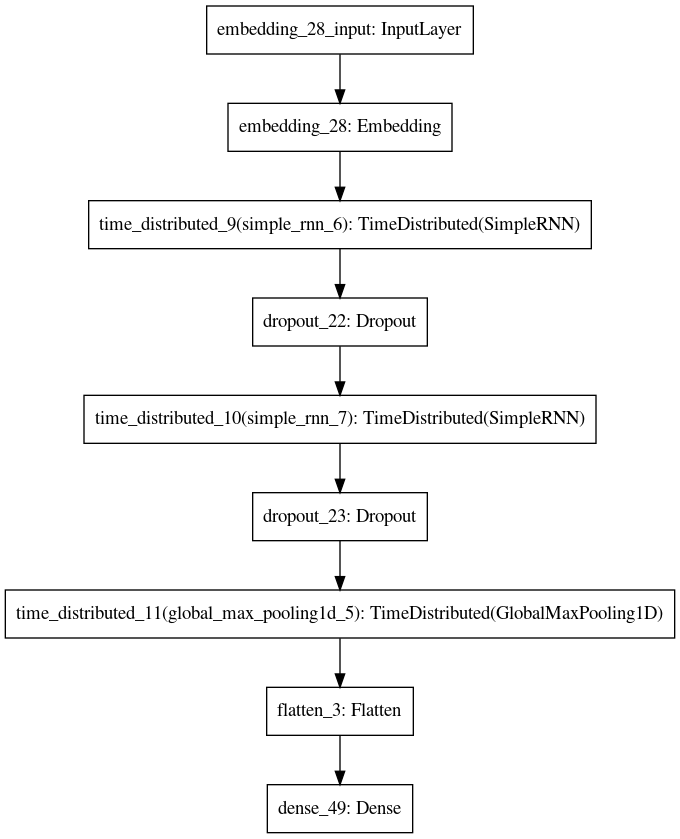

In [226]:
model_rnn.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])
utils.plot_model(model_rnn, show_shapes=False, expand_nested=True, to_file='sentence-pair.png')

## Training the model (RNN)

In [219]:
training = model_rnn.fit(all_sentences,labels,
                         epochs = 100,
                         batch_size = 1024,
                         use_multiprocessing=True,
                         workers=-1,
                    )

Epoch 1/100
21/21 [==============================] - 3s 151ms/step - loss: 0.3049 - accuracy: 0.8642
Epoch 2/100
21/21 [==============================] - 3s 151ms/step - loss: 0.2791 - accuracy: 0.8787
Epoch 3/100
21/21 [==============================] - 4s 176ms/step - loss: 0.2587 - accuracy: 0.8922
Epoch 4/100
21/21 [==============================] - 3s 151ms/step - loss: 0.2539 - accuracy: 0.8930
Epoch 5/100
21/21 [==============================] - 3s 159ms/step - loss: 0.2459 - accuracy: 0.8976
Epoch 6/100
21/21 [==============================] - 4s 174ms/step - loss: 0.2399 - accuracy: 0.9006
Epoch 7/100
21/21 [==============================] - 3s 162ms/step - loss: 0.2384 - accuracy: 0.9014
Epoch 8/100
21/21 [==============================] - 3s 156ms/step - loss: 0.2358 - accuracy: 0.9040
Epoch 9/100
21/21 [==============================] - 4s 199ms/step - loss: 0.2309 - accuracy: 0.9059
Epoch 10/100
21/21 [==============================] - 3s 152ms/step - loss: 0.2253 - accura

## Evaluation

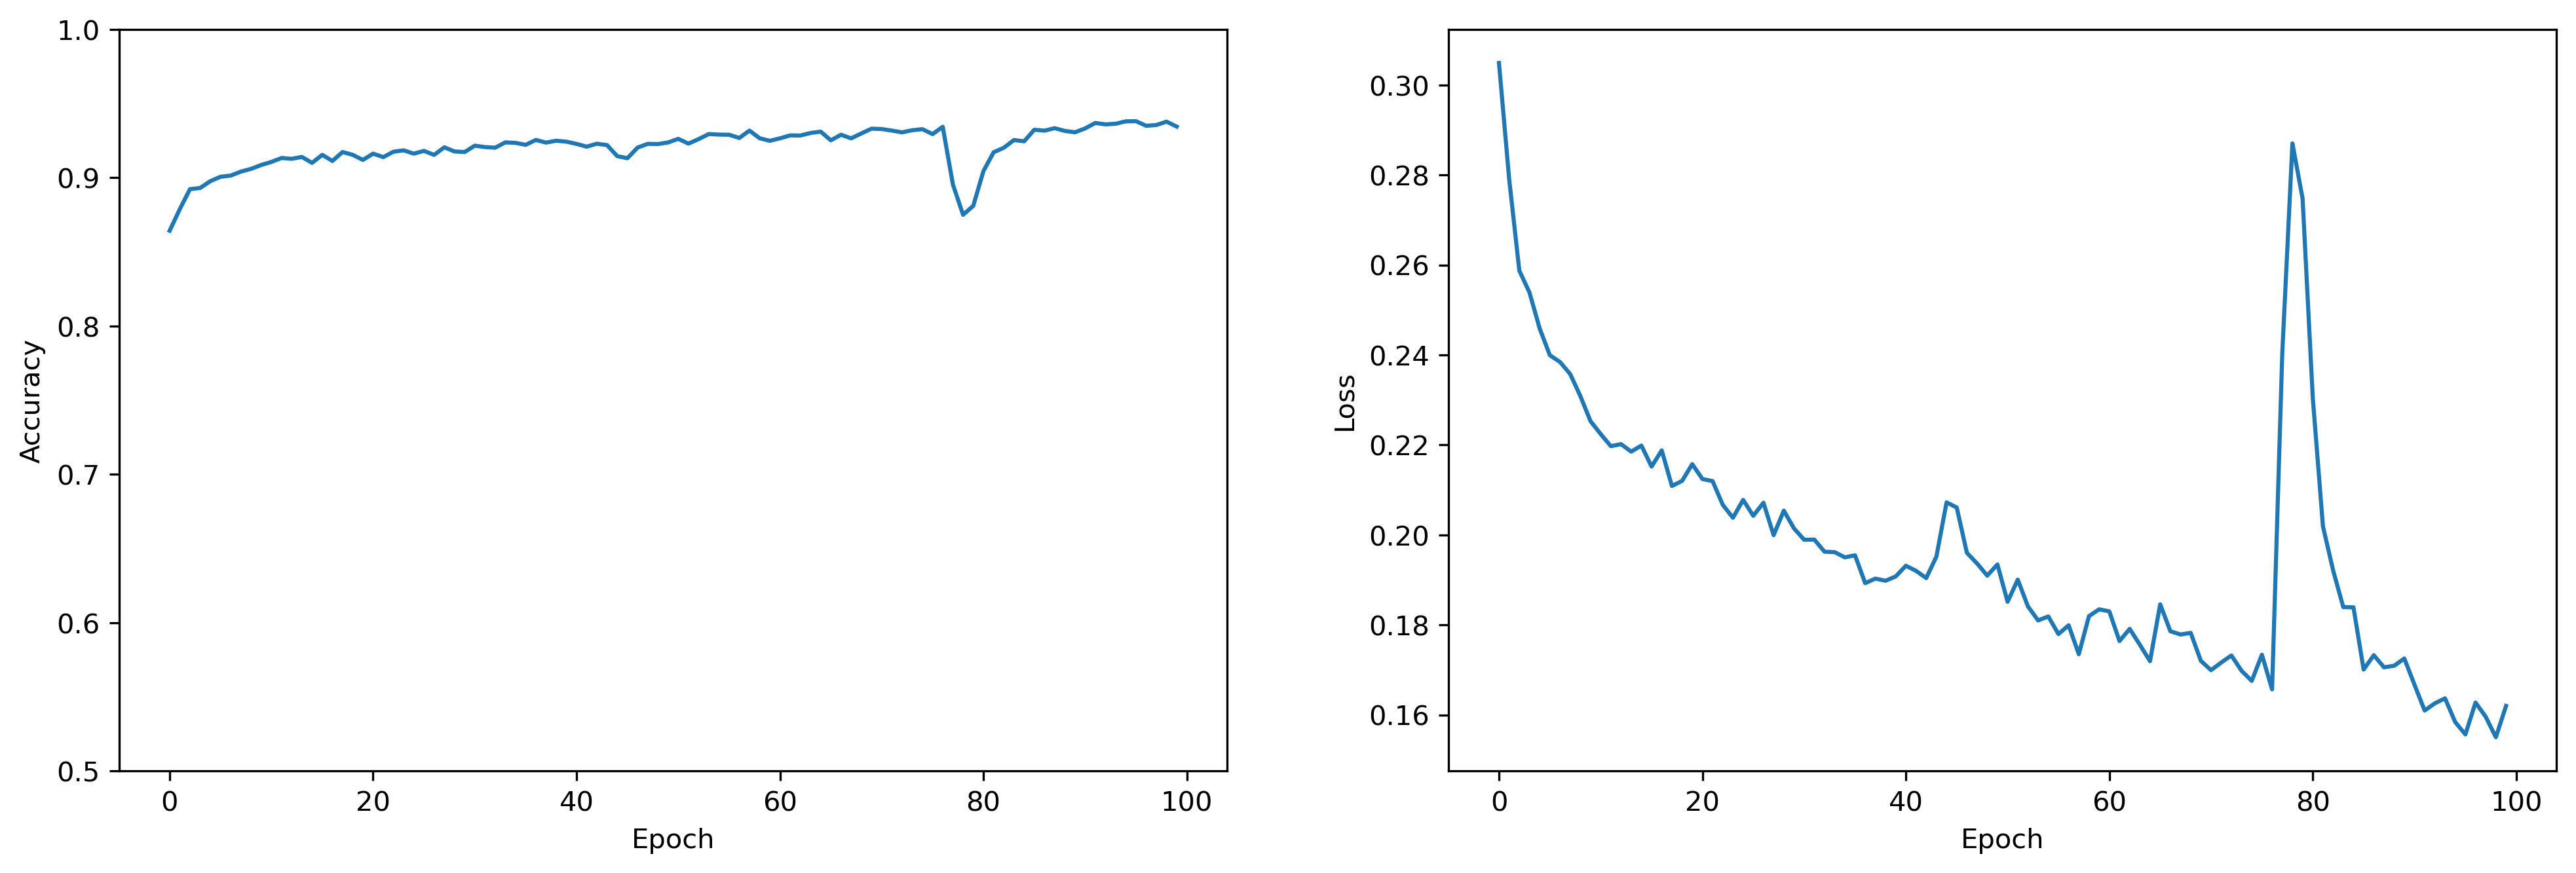

In [224]:
plot_training(training, 'mlni.pdf', valid=False)